Este notebook se basa en realizar EDA a los datos cargados anteriormente en el 002_DataLoad para analizar que patrones o estrategias se pueden tomar de acuerdo a los resultados obtenidos. Y tener una mejor toma de desiciones. 

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print("Current directory before change:", os.getcwd())

try:
    
    os.chdir("../")
    print("Current directory after change:", os.getcwd())

except FileNotFoundError:
    print("""
        FileNotFoundError - The specified directory does not exist or you are already in the root.
        If the code already worked once, do not run it again.
    """)

Current directory before change: c:\Users\Administrador\Desktop\workshop_01\notebooks
Current directory after change: c:\Users\Administrador\Desktop\workshop_01


In [4]:
from db_access.connection import create_engine_connection

engine = create_engine_connection()

In [5]:

# Leer los datos crudos desde la base de datos
df = pd.read_sql("SELECT * FROM candidates", engine)
df

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10
2,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9
3,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1
4,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7
...,...,...,...,...,...,...,...,...,...,...
49995,Bethany,Shields,rocky_mitchell@hotmail.com,2022-01-09,Dominican Republic,27,Trainee,Security,2,1
49996,Era,Swaniawski,dolores.roob@hotmail.com,2020-06-02,Morocco,21,Lead,Game Development,1,2
49997,Martin,Lakin,savanah.stracke@gmail.com,2018-12-15,Uganda,20,Trainee,System Administration,6,1
49998,Aliya,Abernathy,vivienne.fritsch@yahoo.com,2020-05-30,Czech Republic,20,Senior,Database Administration,0,0


In [18]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("Columnas normalizadas:", df.columns.tolist())


📌 Columnas normalizadas: ['first_name', 'last_name', 'email', 'application_date', 'country', 'yoe', 'seniority', 'technology', 'code_challenge_score', 'technical_interview_score']


 Verificar valores nulos

In [40]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("\n🔍 Valores nulos por columna:\n", missing_values[missing_values > 0])
check_missing_values(df)

for col in df.select_dtypes(include=['object']).columns:  # Solo columnas de texto
    empty_values = (df[col] == "").sum() + (df[col] == " ").sum() + (df[col].str.lower() == "null").sum()
    if empty_values > 0:
        print(f"⚠️ Posibles valores nulos ocultos en '{col}': {empty_values}")



🔍 Valores nulos por columna:
 Series([], dtype: int64)


Los datos no tienen valores nulos explícitos ni ocultos.

---

Histograma de años de experiencia y puntajes

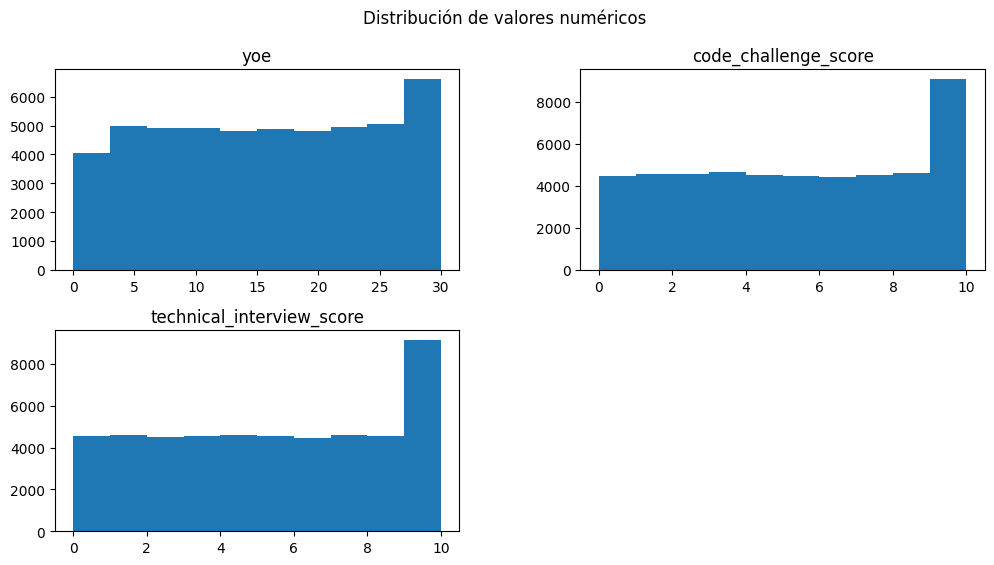

In [ ]:
df[['yoe', 'code_challenge_score', 'technical_interview_score']].hist(figsize=(12, 6), bins=10, grid=False)
plt.suptitle("Distribución de valores numéricos")
plt.show()


Dependiendo de lo anterior podemos ver la presencia de posibles valores atípicos (yoe en 30 años).
Identifica acumulaciones inusuales en los valores máximos (code_challenge_score y technical_interview_score en 10).
entonces, procedemos a verificar esto:

In [23]:
print(df[['yoe', 'code_challenge_score', 'technical_interview_score']].describe())

                yoe  code_challenge_score  technical_interview_score
count  50000.000000          50000.000000               50000.000000
mean      15.286980              4.996400                   5.003880
std        8.830652              3.166896                   3.165082
min        0.000000              0.000000                   0.000000
25%        8.000000              2.000000                   2.000000
50%       15.000000              5.000000                   5.000000
75%       23.000000              8.000000                   8.000000
max       30.000000             10.000000                  10.000000


In [26]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Aplicar la función a cada variable numérica
outlier_columns = ['yoe', 'code_challenge_score', 'technical_interview_score']
outliers = {col: detect_outliers(df, col) for col in outlier_columns}

# Imprimir cantidad de valores atípicos detectados
for col, outlier_df in outliers.items():
    print(f"\n{len(outlier_df)} valores atípicos detectados en '{col}'")
    if not outlier_df.empty:
        print(outlier_df[[col]].head())  # Mostrar algunos valores atípicos



0 valores atípicos detectados en 'yoe'

0 valores atípicos detectados en 'code_challenge_score'

0 valores atípicos detectados en 'technical_interview_score'


---

Boxplot para detectar outliers

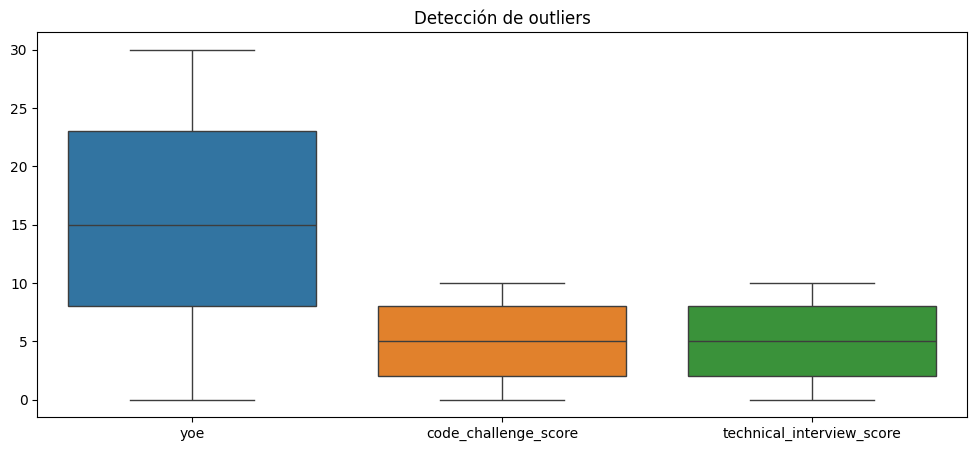

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df[['yoe', 'code_challenge_score', 'technical_interview_score']])
plt.title("Detección de outliers")
plt.show()

Conclusiónes:
- No se encontraron valores atípicos, por lo que no es necesario eliminar datos por outliers.
- Podemos enfocarnos en limpieza de nulos, duplicados y normalización de formatos.
- El histograma sigue siendo útil porque confirma que no hay valores extremos fuera del rango esperado.

--- 

Ver el tipo de las columnas 

In [31]:
print(df.dtypes)

first_name                   object
last_name                    object
email                        object
application_date             object
country                      object
yoe                           int64
seniority                    object
technology                   object
code_challenge_score          int64
technical_interview_score     int64
dtype: object


Matriz correlación 

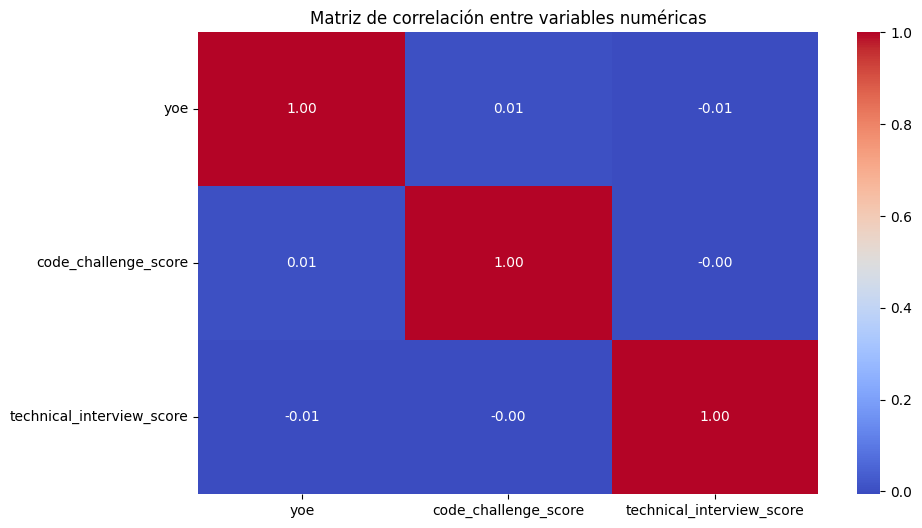

In [ ]:
plt.figure(figsize=(10, 6))
numeric_df = df[['yoe', 'code_challenge_score', 'technical_interview_score']]

sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

Observaciones en esta matriz
yoe (años de experiencia) vs. code_challenge_score → Correlación: 0.01

Casi nula → Tener más años de experiencia no influye directamente en el puntaje del code challenge.
Posible explicación: La experiencia laboral no garantiza habilidades en programación competitiva.
yoe vs. technical_interview_score → Correlación: -0.01

Casi nula y negativa → No hay relación clara entre la experiencia y el desempeño en la entrevista técnica.
Esto sugiere que la experiencia laboral no asegura mejores resultados en entrevistas técnicas.
code_challenge_score vs. technical_interview_score → Correlación: -0.00

Casi nula → Los candidatos que obtienen puntajes altos en el code challenge no necesariamente obtienen buenos puntajes en la entrevista técnica.
Puede deberse a que las entrevistas evalúan otros aspectos (habilidades blandas, resolución de problemas en vivo).
